In [2]:
#TODO bonito only basecalls DNA not RNA?
#TODO load the actual models - install developer version
#TODO install setup.py in develop version of bonito
import os
os.environ.get('CUDA_VERSION')

'11.4.1'

In [3]:
from bonito_pulled.bonito.util import __data__, __models__, __dir__
# list(__dir__.iterdir())
# __data__

In [2]:
from bonito_pulled.bonito.cli.download import main
# main({})

In [1]:
from bonito_pulled.bonito.util import load_model
from bonito_pulled.bonito.util import __models__

#TODO there are multiple models, this one is _fast
dirname = __models__/'dna_r10.4.1_e8.2_fast@v3.5.1'
device = 'cuda'
model = load_model(
    dirname, 
    device, 
    weights=None, 
    half=None, 
    chunksize=None, 
    batchsize=None, 
    overlap=None, 
    quantize=False, 
    use_koi=False
)

print(type(model))
model

<class 'bonito_pulled.bonito.crf.model.Model'>


Model(
  (encoder): Serial(
    (0): Convolution(
      (conv): Conv1d(1, 4, kernel_size=(5,), stride=(1,), padding=(2,))
      (activation): Swish()
    )
    (1): Convolution(
      (conv): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (activation): Swish()
    )
    (2): Convolution(
      (conv): Conv1d(16, 96, kernel_size=(19,), stride=(5,), padding=(9,))
      (activation): Swish()
    )
    (3): Permute()
    (4): LSTM(
      (rnn): LSTM(96, 96)
    )
    (5): LSTM(
      (rnn): LSTM(96, 96)
    )
    (6): LSTM(
      (rnn): LSTM(96, 96)
    )
    (7): LSTM(
      (rnn): LSTM(96, 96)
    )
    (8): LSTM(
      (rnn): LSTM(96, 96)
    )
    (9): LinearCRFEncoder(
      (linear): Linear(in_features=96, out_features=256, bias=True)
      (activation): Tanh()
    )
  )
)

In [88]:
# model = model.encoder[:-1] #SKipping the CRF encoder
import torch
from bonito_pulled.bonito.nn import Permute

seq_model = torch.nn.Sequential(
    model,
    Permute((1,2,0)),
    torch.nn.MaxPool1d(2000), #maxpooling over the whole RNN length, instead do convolution maybe?
    torch.nn.Flatten(),
    torch.nn.Linear(320, 1),
).to('cuda').half()
x = torch.rand(32,1,10000).to('cuda').half()
seq_model(x).shape

torch.Size([32, 1])

In [3]:
import torch
#TODO batch size deosnt matteR? always 1536
x = torch.rand(32,1,10000).to('cuda').half()
out = model(x)
# out = model.decode(x)
out.shape
#Current problem - why is the first dimension changed from 32 (batch size)
# Conv - ok, permute doesnt run? CRF_encoder OK, => rnn or permute
# ? : Reduced sequence length : features
# out

torch.Size([2000, 32, 320])

In [1]:
from bonito_pretrained import RNNPooler, BonitoPretrained
import torch
#200 is the RNN sequence length 
# pooler = RNNPooler(features_to_pool=320, seq_len=200)
# x = torch.rand(200,32,320).to('cuda').half()
# pooler(x).size()

model = BonitoPretrained()

/home/jovyan/my-conda-envs/RNAmodEnv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jovyan/my-conda-envs/RNAmodEnv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


None


In [19]:
# list(model.parameters())
for name, module in list(model.named_modules()):
    # print(child)
    print(name)
    print([p.requires_grad for p in module.parameters()])


[True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True]
model
[True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True]
model.0
[True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True]
model.0.encoder
[True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True]
model.0.encoder.0
[True, True]
model.0.encoder.0.conv
[True, True]
model.0.encoder.0.activation
[]
model.0.encoder.1
[True, True]
model.0.encoder.1.conv
[True, True]
model.0.encoder.1.activation
[]
model.0.encoder.2
[True, Tr

In [80]:
from datamap import experiment_files
index = 0
file_path = experiment_files['pos_2022'][0]
file_path

PosixPath('../../meta/martinekv/store/seq/ont/experiments/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/runs/20220303_1920_MN36569_FAR89595_b610d332/fast5/FAR89595_30596c4a_14.fast5')

In [81]:
from bonito_pulled.bonito.fast5 import get_reads
from pathlib import Path

it = get_reads(str(file_path.parent))
for i in range(index+1):
    read = next(it)
read.signal


array([-0.12388579,  0.0206477 ,  0.6125481 , ...,  0.6676083 ,
        0.8465552 ,  0.33036315], dtype=float32)

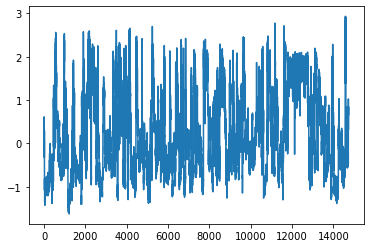

In [82]:
from matplotlib import pyplot as plt
plt.plot(read.signal)

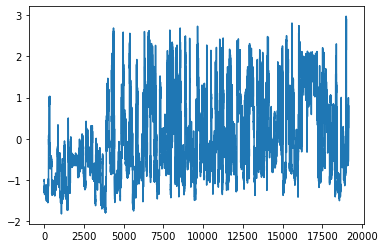

In [83]:
from ont_fast5_api.fast5_interface import get_fast5_file
from scipy import stats

def my_get_reads(scale, zscore):
    with get_fast5_file(file_path, mode='r') as f5:
        for read in f5.get_reads():
            res = read.get_raw_data(scale=scale)
            if(zscore):
                res = stats.zscore(res)
            yield res

it = my_get_reads(scale=True, zscore=True)
for i in range(index+1):
    r = next(it)
plt.plot(r)

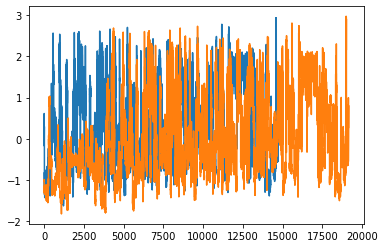

In [84]:
plt.plot(read.signal)
plt.plot(r)